In [4]:
import numpy as np
import pandas as pd
from plotnine import *

In [ ]:
n_users = 10
n_examples = 50
var_users = 1.0
var_examples = 0.6

offset_examples = np.random.normal(loc=0, scale=var_examples, size=n_examples)
offset_users = np.random.normal(loc=0, scale=var_users, size=n_users)

avg_acc = {
    # 'none': np.random.normal(loc=0.51, scale=var_examples, size=n_examples),
    # 'only_label': np.random.normal(loc=0.62, scale=var_examples, size=n_examples),
    # 'rand_wo_label': np.random.normal(loc=0.54, scale=var_examples, size=n_examples),
    # 'rand': np.random.normal(loc=0.70, scale=var_examples, size=n_examples),
    # 'best': np.random.normal(loc=0.74, scale=var_examples, size=n_examples),
    # 'model': np.random.normal(loc=0.87, scale=var_examples, size=n_examples),
    # 'bandit': np.geomspace(loc=0.70, scale=0.77, size=n_examples)
    'rand ew': np.random.normal(loc=0.26, scale=var_examples, size=n_examples),
    'none ew': np.random.normal(loc=0.22, scale=var_examples, size=n_examples),
    'all ew': np.random.normal(loc=0.24, scale=var_examples, size=n_examples),
    'qanta ew': np.random.normal(loc=0.26, scale=var_examples, size=n_examples),
    'bandit ew': np.geomspace(start=0.26, stop=0.27, num=n_examples)
}
avg_acc = {c: x + offset_examples for c, x in avg_acc.items()}
for key, value in avg_acc.items():
    np.random.shuffle(avg_acc[key])
    
reward = {
    condition: np.asarray([np.random.binomial(1, max(0, min(1, x)), size=n_users) for x in xs])
    for condition, xs in avg_acc.items()
}
accu_reward = {
    condition: np.add.accumulate(rs.mean(axis=1), axis=0)
    for condition, rs in reward.items()
}
# # point uncertainty
var_reward_ptn = {
    condition: rs.std(axis=1)
    for condition, rs in reward.items()
}
# path uncertainty
var_reward_pat = {
    condition: np.std(np.add.accumulate(rs, axis=0), axis=1)
    for condition, rs in reward.items()
}

x, y, ymin_ptn, ymax_ptn, ymin_pat, ymax_pat, label = [], [], [], [], [], [], []
for condition, rs in accu_reward.items():
    for i, r in enumerate(rs):
        x.append(i)
        y.append(r)
        ymin_ptn.append(r - var_reward_ptn[condition][i] / 2)
        ymax_ptn.append(r + var_reward_ptn[condition][i] / 2)
        ymin_pat.append(r - var_reward_pat[condition][i] / 2)
        ymax_pat.append(r + var_reward_pat[condition][i] / 2)
        label.append(condition)
        
df = pd.DataFrame({
    'x': x,
    'y': y,
    'ymin_ptn': ymin_ptn,
    'ymax_ptn': ymax_ptn,
    'ymin_pat': ymin_pat,
    'ymax_pat': ymax_pat,
    'label': label
})

p0 = (
    ggplot(df)
    + aes(x='x', y='y', ymin='ymin_ptn', ymax='ymax_ptn', color='label', fill='label')
    + geom_line()
    + geom_ribbon(alpha=0.3)
)

p1 = (
    ggplot(df)
    + aes(x='x', y='y', ymin='ymin_pat', ymax='ymax_pat', color='label', fill='label')
    + geom_line()
    + geom_ribbon(alpha=0.3)
)

p1

In [ ]:
p1.save('new.pdf')

100%|██████████| 13/13 [00:00<00:00, 2453.80it/s]


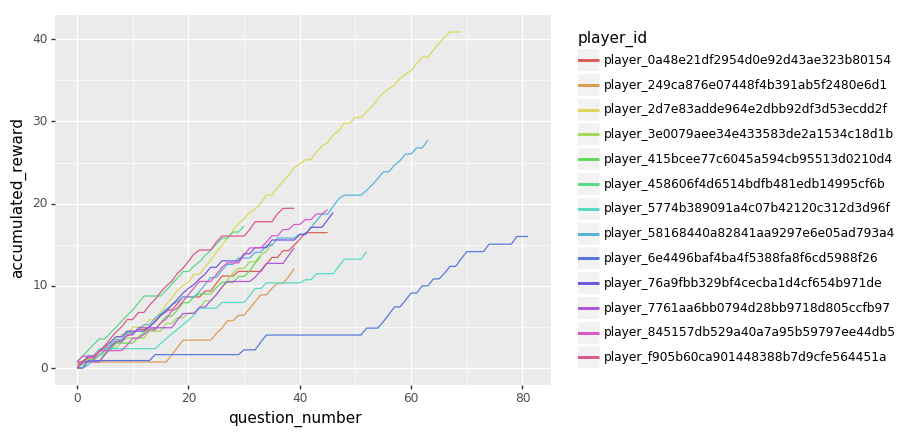

<ggplot: (8778574966941)>

In [141]:
import pickle
import itertools
import multiprocessing
from tqdm import tqdm
from joblib import Parallel, delayed

from db import QBDB
from util import QBQuestion
from expected_wins import ExpectedWins

db = QBDB()
ew = ExpectedWins()

def apply_parallel(f, groupby):
    return Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(f)(group) for name, group in tqdm(groupby))

with open('data/pace_questions.pkl', 'rb') as f:
    questions = pickle.load(f)
    questions = {q.qid: q for q in questions}
    
df = pd.DataFrame(db.get_records())

""""
drop rows with NaN
count the number of records for each player
remove players with fewer than min_player_records records
"""
min_player_records = 30
df = df.dropna()
player_record_count = df.player_id.value_counts()
player_record_count_df = pd.DataFrame({
    'player_id': player_record_count.index,
    'player_record_count': player_record_count.values
})
df = df.set_index('player_id').join(player_record_count_df.set_index('player_id')).reset_index()
df = df[df['player_record_count'] > min_player_records]

"""
compute EW score for each record
"""
def get_ew(row):
    text = questions[row.question_id].raw_text
    return row.result * ew.score(row.position_buzz, len(text))
    
df['ew'] = df.apply(get_ew, axis=1)


def get_group_features(g):
    # for each user, set incremental question number
    # return a list of record_ids and a list question numbers
    return (
        g.record_id.tolist(),
        g.reset_index().index.tolist(),
        # np.cumsum(g.result.tolist()).tolist(),
        np.cumsum(g.ew.tolist()).tolist(),
    )

feature_names = [
    'question_number',
    'accumulated_reward',
]

features = apply_parallel(get_group_features, df.groupby('player_id'))
features = zip(*features)
features = [itertools.chain(*x) for x in features]
index, features = list(features[0]), features[1:]
features = [{k: v for k, v in zip(index, fs)} for fs in features]
for fn, fs in zip(feature_names, features):
    df[fn] = df['record_id'].map(fs)

(
    ggplot(df)
    + geom_line(
        aes(x='question_number', y='accumulated_reward', color='player_id', fill='player_id')
    )
) 

In [158]:
class theme_fs(theme_light):
    """
    A theme similar to :class:`theme_linedraw` but with light grey
    lines and axes to direct more attention towards the data.

    Parameters
    ----------
    base_size : int, optional
        Base font size. All text sizes are a scaled versions of
        the base font size. Default is 11.
    base_family : str, optional
        Base font family.
    """

    def __init__(self, base_size=11, base_family='DejaVu Sans'):
        theme_light.__init__(self, base_size, base_family)
        self.add_theme(theme(
            axis_ticks=element_line(color='#DDDDDD', size=0.5),
            panel_border=element_rect(fill='None', color='#838383', size=1),
            strip_background=element_rect(fill='#DDDDDD', color='#838383', size=1),
            strip_text_x=element_text(color='black'),
            strip_text_y=element_text(color='black', angle=-90),
            legend_key=element_blank(),
        ), inplace=True)

In [166]:
TOOLS = ['guesses', 'highlight', 'matches']

# density plot of EW w/wo each tool
for tool_name in TOOLS:
    fig_dir = 'figures/{}_ew_density.pdf'.format(tool_name)
    plot_df = {
        'EW': [],
        'Enabled': [],
    }
    for row in df.itertuples():
        enabled = row.enabled_tools[tool_name]
        plot_df['EW'].append(row.ew)
        plot_df['Enabled'].append(tool_name + (' on' if enabled else ' off'))
    plot_df = pd.DataFrame(plot_df)
    
    p = (
        ggplot(plot_df)
        + geom_density(
            aes(
                x='EW',
                fill='Enabled',
            ),
            alpha=0.5,
        )
        + theme_fs()
        + theme(
            aspect_ratio=0.5,
            axis_text_x=element_text(size=16),
            axis_text_y=element_text(size=16),
            axis_title_x=element_text(size=16),
            axis_title_y=element_blank(),
            legend_text=element_text(size=16),
            legend_title=element_blank(),
            strip_text=element_text(size=16),
        )
    )
    p.save(fig_dir)

/fs/clip-quiz/shifeng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/fs/clip-quiz/shifeng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/guesses_ew_density.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/fs/clip-quiz/shifeng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/fs/clip-quiz/shifeng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/highlight_ew_density.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/fs/clip-quiz/shifeng/anaconda3/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/fs/clip-quiz/shifeng/anaconda3/lib/python3.7/site-